# Complete pipeline

## Introductory notes:
This notebook presents minimal functionality needed to go through the cleaning, ICA, spectral, and event analysis stages.
* For the cleaning part, the functionality consists of resampling, filtering, bad channels and bad data spans annotation, and bad channels interpolation.
* For the ICA part, it is fitting and selecting components you want to exclude.
* For the spectral analyses part, it is spectrogram+hypnogram, PSD per sleep stage, and topomap per sleep stage per frequency band.
* For the detection of the events, it is spindles, slow waves, and rapid eye movements detection and analysis.

For the extended functionality check out the corresponding notebooks.

## Import module

In [ ]:
import os
import sys
import sleepeegpy
import mne
mne.set_log_level('WARNING')

### Run the following code

In [5]:
###### This code contains widgets that will be previewed later in the notebook. ######
####### Run this code and continue. ######
import ipywidgets as widgets
from IPython.display import display

use_example_set = widgets.RadioButtons(
    options=[True, False], description="Use example set?", value=True
)
bad_channels_selection = widgets.RadioButtons(
    options=["automatically", "manually", "from-file"],
    description="Clean Bad Channels:",
    value="from-file",
)
annotations_selection = widgets.RadioButtons(
    options=["automatically", "manually", "from-file"],
    description="Clean bad epochs Annotations:",
    value="from-file",
)

hypno_selection = widgets.RadioButtons(
    options=["automatically", "from-file"], description="Hypnogram:", value="from-file"
)

In [6]:
import pooch
from sleepeegpy.pipeline import (
    CleaningPipe,
    ICAPipe,
    SpectralPipe,
    SpindlesPipe,
    SlowWavesPipe,
    RapidEyeMovementsPipe,
)
from sleepeegpy.dashboard import create_dashboard

## Setup Input Files

By default, all the input files are assumed to be saved in <b>input_files</b>, which will be created (if not already exist) in the notebook path. Change the following strings to use another path.
Changing the output directory is also optional.

In [7]:
from os import makedirs

output_dir = "output_folder"  # Output path and name can be changed here
input_dir = "input_files"  # input files dir can be changed here
makedirs(input_dir, exist_ok=True)
makedirs(output_dir, exist_ok=True)

### Pipeline preference:
Change the values according to how you want to use the pipeline.

In [8]:
display(use_example_set)
display(bad_channels_selection)
display(annotations_selection)
display(hypno_selection)

RadioButtons(description='Use example set?', options=(True, False), value=True)

RadioButtons(description='Clean Bad Channels:', index=2, options=('automatically', 'manually', 'from-file'), v…

RadioButtons(description='Clean bad epochs Annotations:', index=2, options=('automatically', 'manually', 'from…

RadioButtons(description='Hypnogram:', index=1, options=('automatically', 'from-file'), value='from-file')

### Add requested files
Run the code below, add all requested files (according to your preference) in the input file, and write their names.

Instructions:
- Put your files in the input directory.
- EEG file must include a montage that works with mne.read_raw.
- For more information about the mne.read_raw supported formats, see [mne documentation](https://mne.tools/stable/generated/mne.io.Raw.html)
- If your file has no montage, but there is a channel mapping, you can add montage in the cleaning part (there is an example below of one way to add it).

In [9]:
#### If you use your own files (not the example set), write the relevant filenames below. ###

subject_code = "DK8"  # The subject code that will appear in the dashboard
eeg_file = "resampled_raw.fif"
bad_channels = "bad_channels.txt"
annotations = "annotations.txt"

If you are using hypnogram file:
* Modify your hypnogram file name (Point-per-row type of hypnogram) below. 
* If needed, change the Hypnogram's sampling frequency
* If you don't have a hypnogram file, follow the next notebook instructions.

In [10]:
hypnogram_filename = "staging.txt"
hypno_freq = 1  # If required, change the Hypnogram's sampling frequency (Visbrain's hypnograms default to 1)

### Modify hypnogram prediction arguments
<b>If you don't have hypnogram file</b>, choose prediction arguments.
These values will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging) to create a new hypnogram. 

<b> Make sure the selected channel names exist in your montage </b>

In [11]:
if hypno_selection.value == "automatically":
    hypnogram_path = "predict"
    #### If you selected automatic hypnogram, select prediction arguments. ####
    hypno_predict_arguments = {
        "eeg_name": "E183",  # (C4)
        "eog_name": "E252",  # (EOG1)
        "emg_name": "E247",
        "ref_name": "E26",
        "save": False,
    }
else:
    hypno_predict_arguments = None

#### Adjust variables
* If required, change `n_components` - should equal or less than the number of channels. see [more information](https://mne.tools/stable/generated/mne.preprocessing.ICA.html)
* Modify the picked channel. `picked_channel` represents the EEG channel selected for plotting and computations of hypnospectrogram, PSDs, and TFRs.
* Modify the variable in the next notebook cells, to have separate channels for each plot.
* Modify loc_chname and roc_chname (EOG). For more information see: [Left and Right Ocular Canthi](https://raphaelvallat.com/yasa/build/html/generated/yasa.rem_detect.html).
* Make sure all channel names are part of the montage.

In [12]:
n_components = 30
picked_channel = "E101"  # (Pz)
loc_chname = "E252"  # (EOG1)
roc_chname = "E226"  # (EOG2)

<b> You can now run the notebook (you can change values according to your needs)</b>

In [13]:
if use_example_set.value:
    cache_dir = pooch.os_cache("sleepeegpy_dataset")
    doi = "10.5281/zenodo.10362189"
    odie = pooch.create(
        path=cache_dir,
        base_url=f"doi:{doi}",
    )
    odie.load_registry_from_doi()

In [14]:
if use_example_set.value:
    ## Nap dataset files: ##
    bad_channels = odie.fetch("nap_bad_channels.txt")
    annotations = odie.fetch("nap_annotations.txt")
    path_to_eeg = odie.fetch("nap_resampled_raw.fif", progressbar=True)
    if hypno_selection.value == "from-file":
        hypnogram_path = odie.fetch("nap_staging.txt", progressbar=True)
else:
    path_to_eeg = os.path.join(input_dir, eeg_file)
    if hypno_selection.value == "from-file":
        hypnogram_path = os.path.join(input_dir, hypnogram_filename)
    bad_channels = (
        None
        if bad_channels_selection == "automatically"
        else os.path.join(input_dir, bad_channels)
    )
    annotations = (
        None
        if annotations_selection == "automatically"
        else os.path.join(input_dir, annotations)
    )

## Cleaning

Initialize `CleaningPipe` object by providing it with path to eeg file and output directory in which you want the data to be saved.

In [15]:
pipe = CleaningPipe(
    path_to_eeg=path_to_eeg,
    output_dir=output_dir,
)

In [16]:
##### Adding montage example ####
# import mne
# channels_map = {"E59": "C3", "E183": "C4", "E36": "F3", "E224": "F4", "E47": "F7", "E2": "F8","E37": "Fp1", "E18": "Fp2", "E21": "Fz", "E116": "O1", "E150": "O2", "E87": "P3", "E153": "P4", "E101": "Pz","E69": "T3", "E202": "T4", "E96": "T5", "E170": "T6", "E94": "A1", "E190": "A2"}
# current_channel_names = set(pipe.mne_raw.ch_names)
# channels_to_drop = list(current_channel_names - set(channels_map.keys()))
# pipe.mne_raw.drop_channels(channels_to_drop)
# mne.rename_channels(pipe.mne_raw.info, channels_map)
# montage = mne.channels.make_standard_montage('standard_1020')
# pipe.mne_raw.set_montage(montage)

### Resampling
This can take more than an hour depending on eeg signal size and specs of the computer you're running the analysis on.

In [17]:
pipe.resample(sfreq=250)

In [18]:
pipe.filter(l_freq=0.75, h_freq=40)

In [19]:
pipe.notch(freqs="50s")

### Select bad channels and epochs

If manually bad channels were selected, select bad channels in the pop-up window.
Note that automatically bad channels selection takes time.

In [20]:
if bad_channels_selection.value == "manually":
    pipe.plot(save_bad_channels=True)
elif bad_channels_selection.value == "automatically":
    bad_channels = pipe.auto_detect_bad_channels()

In [21]:
pipe.read_bad_channels(
    path=None if bad_channels_selection.value == "Manually" else bad_channels
)

In [22]:
pipe.interpolate_bads(reset_bads=True)

Interpolated channels: ['E9', 'E45', 'E54', 'E122', 'E200', 'E256', 'VREF']


Select bad epochs

Click "a" -> "Add description" -> Enter BAD_EPOCH -> Annotate bad data spans

In [23]:
if annotations_selection.value == "manually":
    pipe.plot(butterfly=True, save_annotations=True, overwrite=True)
    pipe.read_annotations()
elif annotations_selection.value == "from-file":
    pipe.read_annotations(path=annotations)
elif annotations_selection.value == "automatically":
    pipe.auto_set_annotations()

average reference has been applied
Hypnogram is SHORTER than data by 0.0 seconds. Padding hypnogram with last value to match data.size.


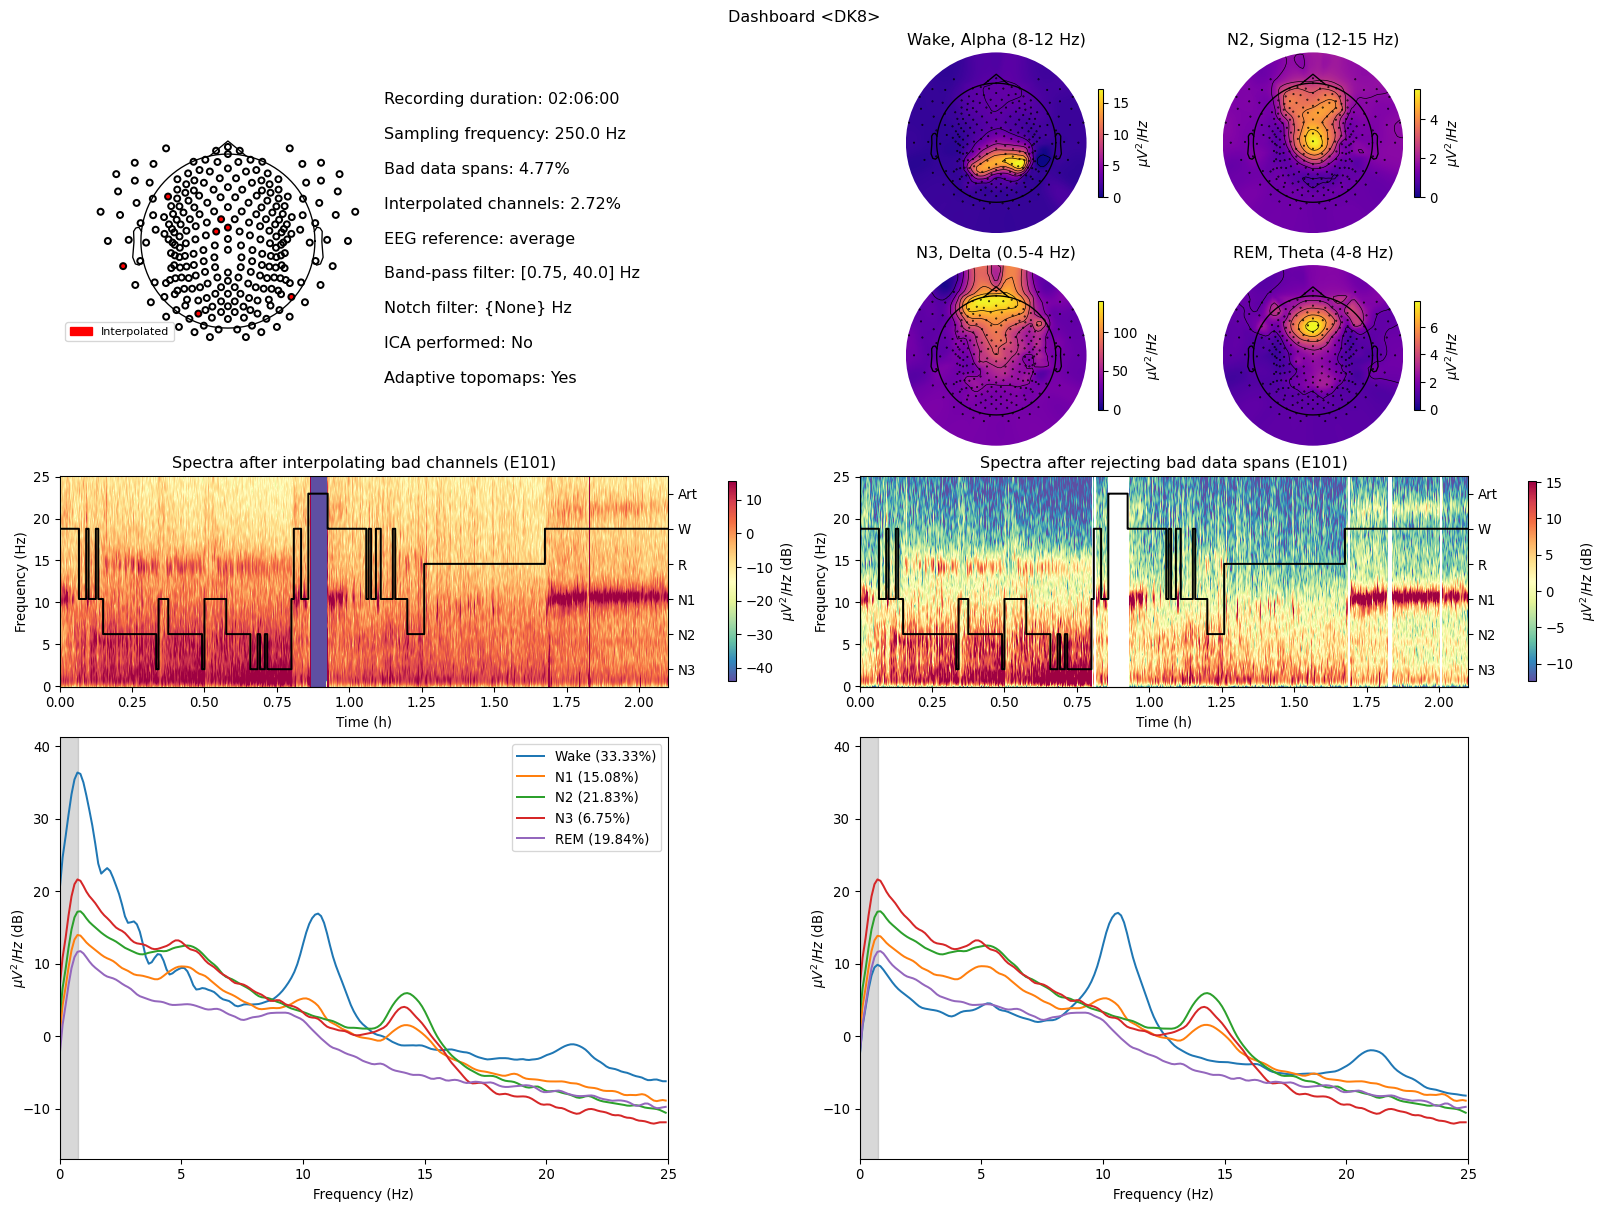

In [24]:
fig = create_dashboard(
    subject_code=subject_code,
    prec_pipe=pipe,
    hypno_psd_pick=picked_channel,
    hypnogram=hypnogram_path,
    predict_hypno_args=hypno_predict_arguments,
    hypno_freq=hypno_freq,
    reference="average",
)

## ICA

Pass the preceding (cleaning) pipe to the ICAPipe.

In [25]:
ica_pipe = ICAPipe(prec_pipe=pipe, n_components=n_components)

Fit the ICA on the 1 Hz high-pass filtered data.

In [26]:
ica_pipe.fit()

Visually inspect ICA components.

In [27]:
ica_pipe.plot_sources()

2024-10-13 13:38:10,712 - OpenGL.acceleratesupport - INFO - No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


Pass to the `exclude` argument indices of components you want to remove from the raw signal.

In [28]:
ica_pipe.apply()

Excluded ICA components: []


## Spectral

Pass the preceding (cleaning or ICA) pipe to the SpectralPipe. Also provide pass to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [29]:
spectral_pipe = SpectralPipe(
    prec_pipe=ica_pipe,
    path_to_hypno=hypnogram_path,
    hypno_freq=hypno_freq,
)

Hypnogram is SHORTER than data by 0.0 seconds. Padding hypnogram with last value to match data.size.


If you don't have a hypnogram, `predict_hypno` will use [YASA's algorithm](https://raphaelvallat.com/yasa/build/html/generated/yasa.SleepStaging.html#yasa.SleepStaging). 

In [30]:
if hypnogram_path is None:
    spectral_pipe.predict_hypno(
        eeg_name=hypno_predict_arguments["eeg_name"],
        eog_name=hypno_predict_arguments["eog_name"],
        emg_name=hypno_predict_arguments["emg_name"],
        ref_name=hypno_predict_arguments["ref_name"],
        save=False,
    )

By default, picked_channel will be used to calculate spectrogram. You can pass another electrode name (make sure it exists)

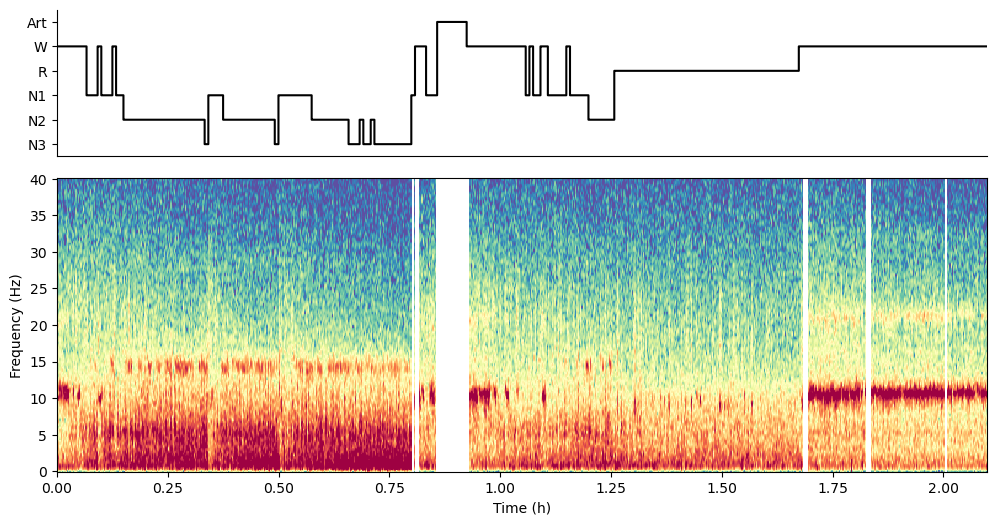

In [31]:
spectral_pipe.plot_hypnospectrogram(picks=[picked_channel])

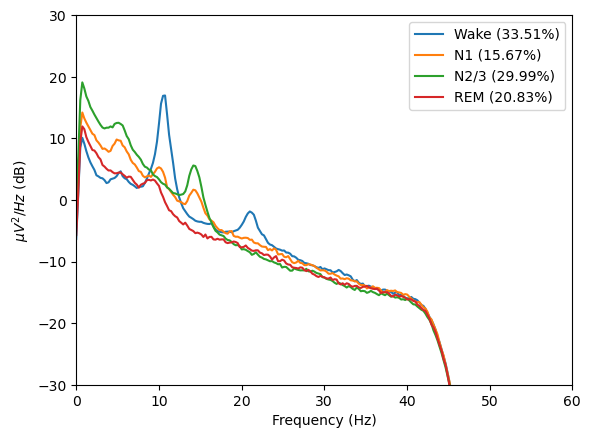

In [32]:
spectral_pipe.compute_psd(
    sleep_stages={"Wake": 0, "N1": 1, "N2/3": (2, 3), "REM": 4},
    reference="average",
    # Additional arguments passed to the Welch method:
    n_fft=1024,
    n_per_seg=1024,
    n_overlap=512,
    window="hamming",
    verbose=False,
)
spectral_pipe.plot_psds(picks=[picked_channel], psd_range=(-30, 30))

Create a collage with rows for sleep stages and columns for bands.

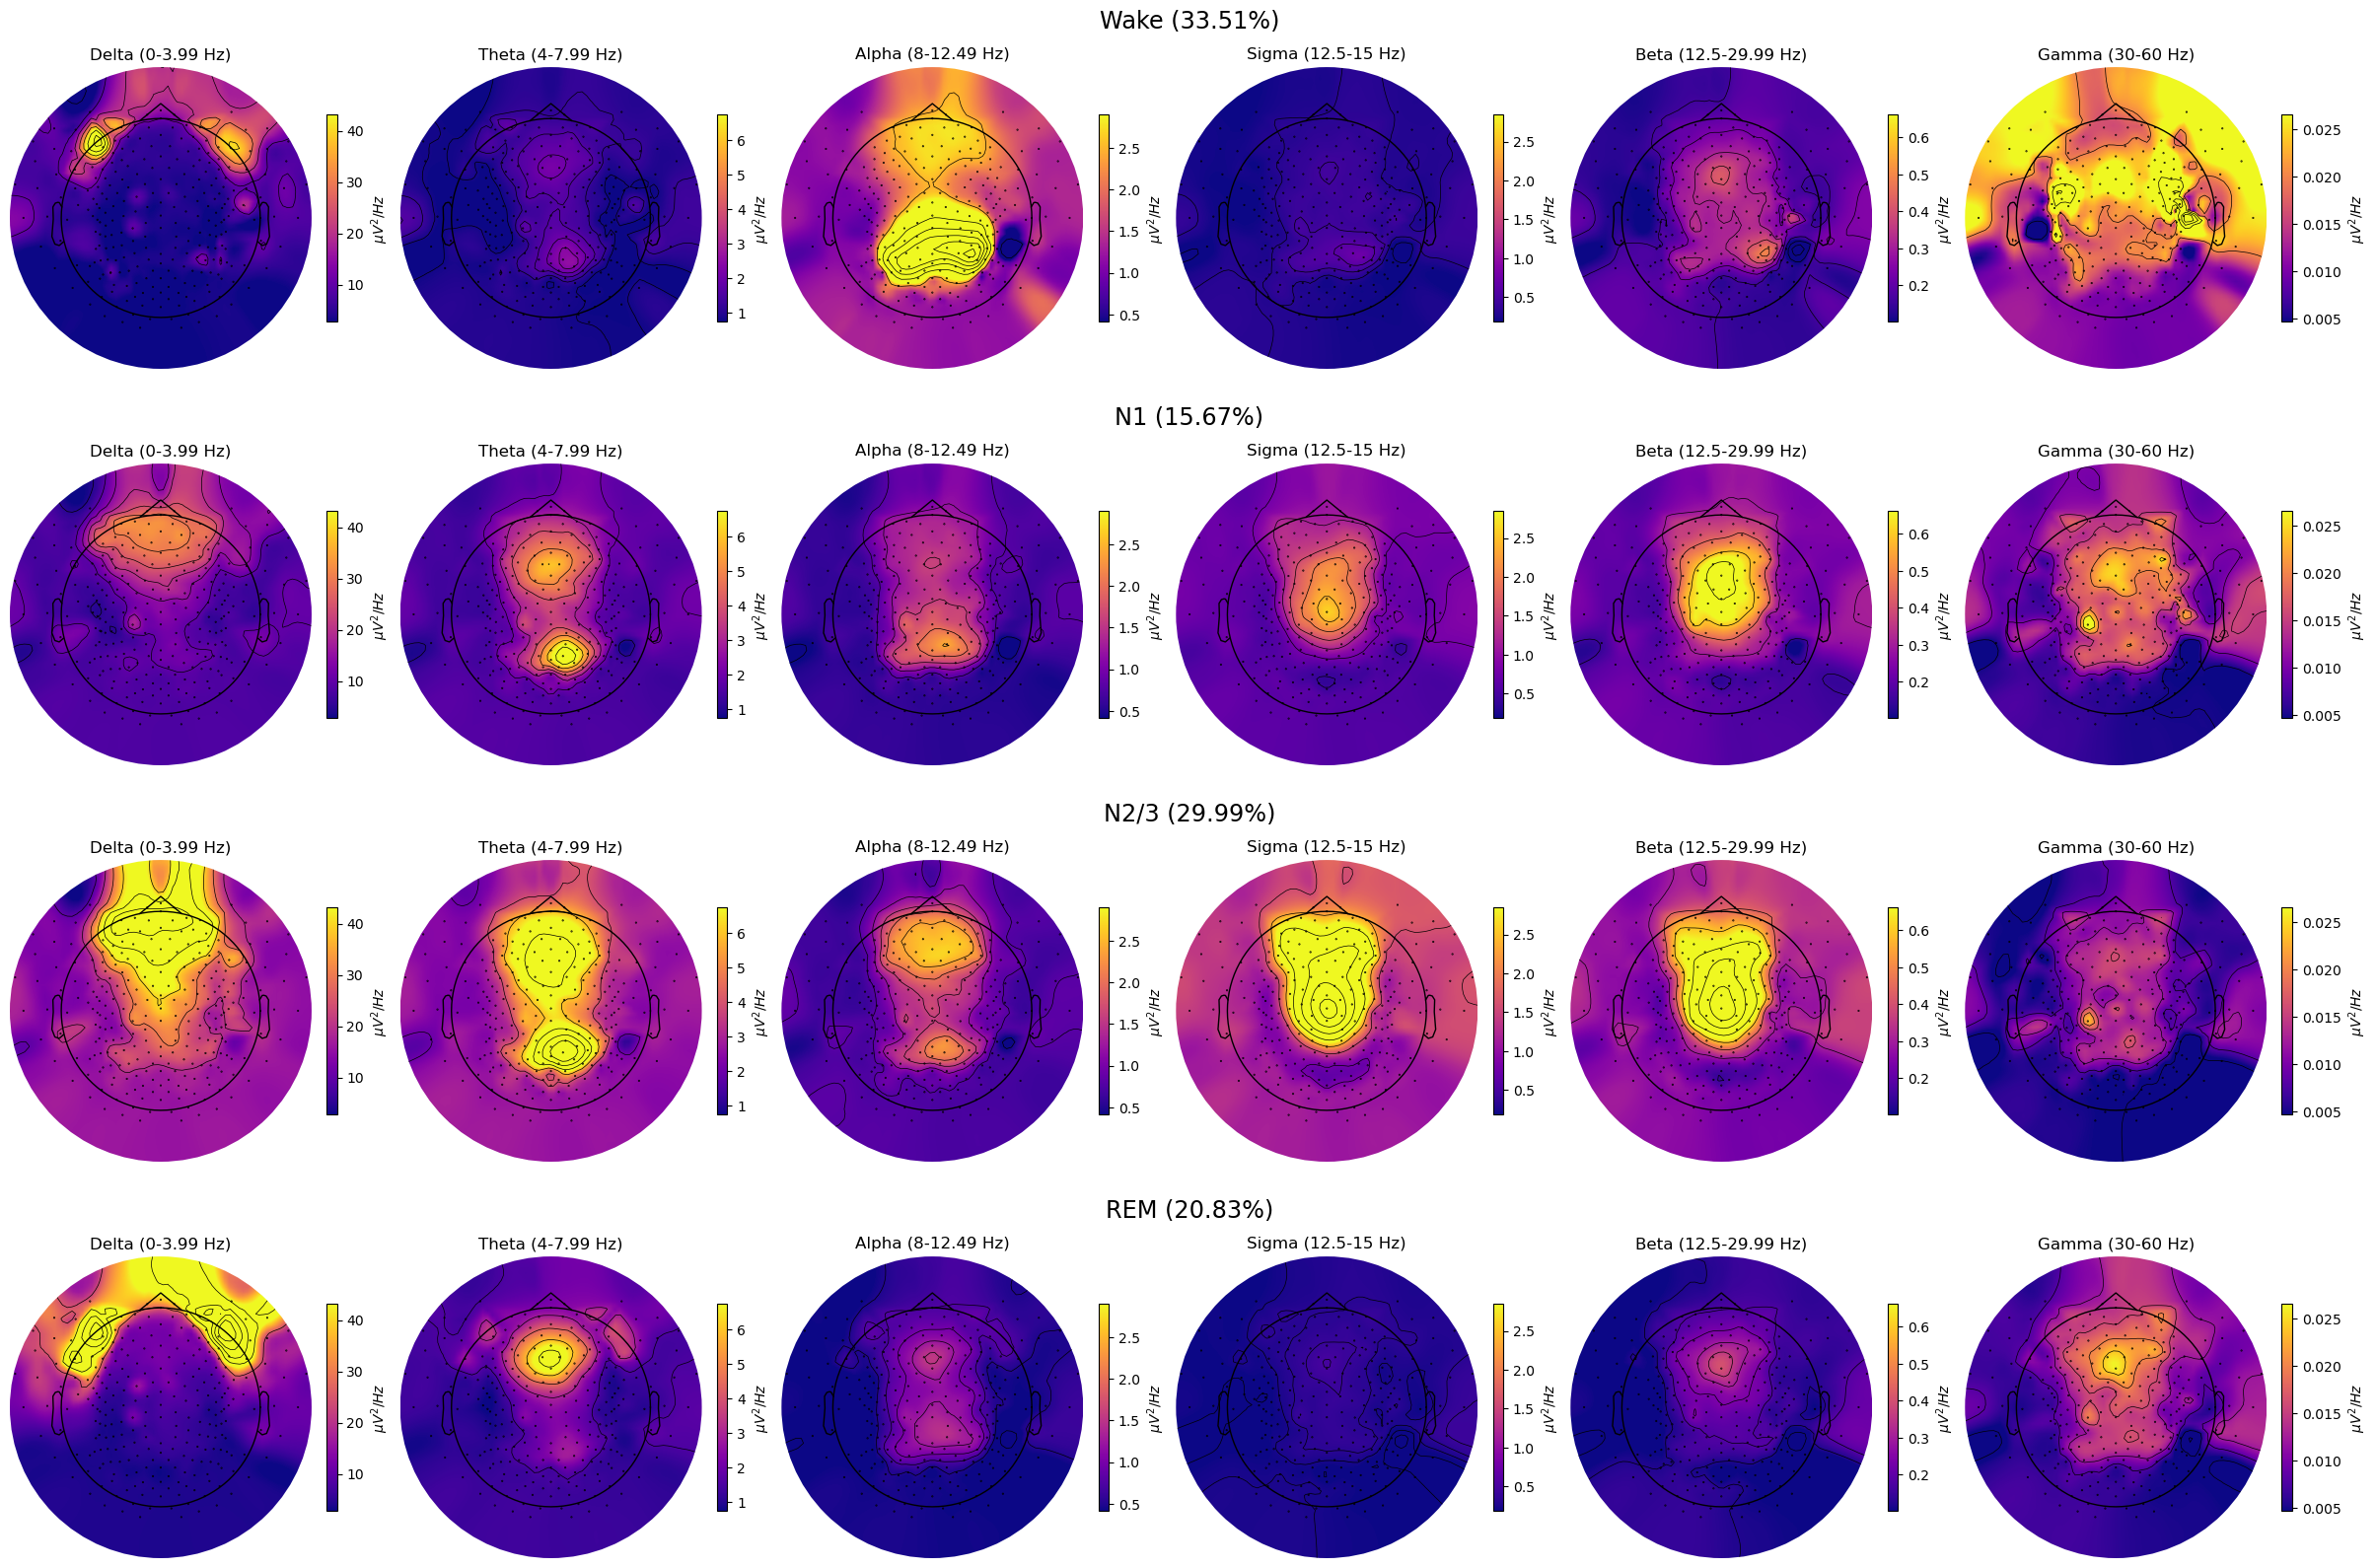

In [33]:
spectral_pipe.plot_topomap_collage()

## Events

Pass the preceding (cleaning or ICA or spectral) pipe to one of the SpindlesPipe, SlowWavesPipe, or RapidEyeMovementsPipe. If the preceding is cleaning or ICA - provide a path to the hypnogram and don't forget to pass its frequency to the corresponding parameter.

In [ ]:
spindles_pipe = SpindlesPipe(prec_pipe=spectral_pipe)

spindles_pipe.detect()
spindles_pipe.plot_average(
    center="Peak",
    hue="Stage",
    time_before=1,
    time_after=1,
)

Hypnogram is SHORTER than data by 0.0 seconds. Padding hypnogram with last value to match data.size.
/Users/yardenmezi/miniconda3/envs/notebook/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    4.7s


Setting up band-pass filter from 12 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 12.00
- Lower transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 1.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 551 samples (2.204 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    2.2s


In [ ]:
spindles_pipe.results.summary(grp_chan=False, grp_stage=True)

In [ ]:
spindles_pipe.compute_tfr(freqs=(10, 20), n_freqs=100, time_before=1, time_after=1)
spindles_pipe.tfrs["N2"].plot([picked_channel])

In [ ]:
slow_waves_pipe = SlowWavesPipe(prec_pipe=spindles_pipe)
slow_waves_pipe.detect()

slow_waves_pipe.plot_average(
    center="NegPeak",
    hue="Stage",
    time_before=0.4,
    time_after=0.8,
)

In [ ]:
slow_waves_pipe.compute_tfr(
    freqs=(0.5, 5), n_freqs=100, time_before=4, time_after=4, n_cycles=2
)
ploted_channel = "VREF"  # Cz
slow_waves_pipe.tfrs["N3"].plot([picked_channel])

In [ ]:
rems_pipe = RapidEyeMovementsPipe(prec_pipe=slow_waves_pipe)

rems_pipe.detect(
    loc_chname=loc_chname,
    roc_chname=roc_chname,
)

rems_pipe.plot_average(
    center="Peak",
    time_before=0.5,
    time_after=0.5,
    filt=(None, None),
    mask=None,
)